In [119]:
import cv2,os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
# from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

In [53]:
path = "../../Datasets/211202NDA/NDAcquisition-01_XY256.ome.tif"
path = "../../Datasets/dog.jpeg"
# img = Image.open(path)
# img = img.resize((512,512))
# print(img.format)
# print(img.size)
# print(img.mode)
# print(img.getextrema())
# img.show()

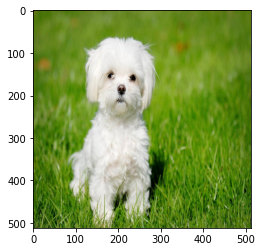

In [59]:
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(512,512))
plt.imshow(img)

In [60]:
transform = transforms.Compose([transforms.ToTensor()])

In [61]:
# weights_path = '../../Datasets/weights/mask_rcnn_kaggle_v1.h5'
# weights = torch.load(weights_path)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# model.load_state_dict(torch.load(weights_path))

In [109]:
model.eval()
output = model(transform(img).unsqueeze(0))[0]

print(output["boxes"].shape)
print(output["labels"].shape)
print(output["scores"].shape)
print(output["masks"].shape)

print(output["labels"])
print(output["scores"])

torch.Size([1, 4])
torch.Size([1])
torch.Size([1])
torch.Size([1, 1, 512, 512])
tensor([18])
tensor([0.9993], grad_fn=<IndexBackward0>)


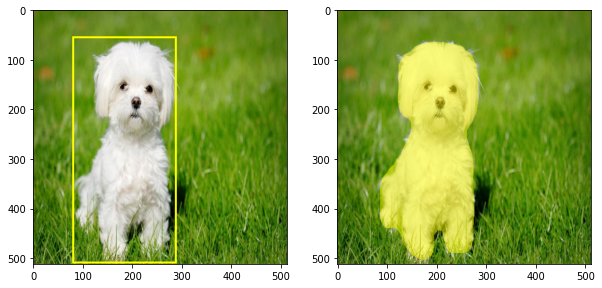

In [224]:
score_threshold = 0.8
backimg = torch.tensor(np.transpose(img,(2,0,1)))
colors = ["yellow"]

boxes = output['boxes'][output['scores'] > score_threshold]
with_boxes = draw_bounding_boxes(backimg, boxes, colors=colors, width=4)

masks = output['masks'][output['scores'] > score_threshold][0].ge(0.5)
with_masks = draw_segmentation_masks(backimg, masks, alpha=0.5, colors=colors)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(with_boxes,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(with_masks,(1,2,0)))

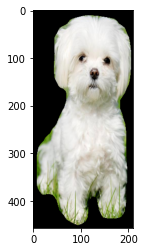

In [253]:
backimg = torch.tensor(np.transpose(img,(2,0,1)))

im = backimg.masked_fill_(masks==False, 0)
im = np.transpose(im,(1,2,0))
x1,x2,y1,y2 = int(boxes[0,1].item()),int(boxes[0,3].item()),int(boxes[0,0].item()),int(boxes[0,2].item())
im = im[x1:x2,y1:y2,:]

plt.imshow(im)